# Train a LoRA for Stable Diffusion 3.5 (SD3.5)

Goal: fine-tune SD 3.5 to your dataset using a **LoRA** (Diffusers + Accelerate).

This notebook is designed to be robust across Diffusers versions by auto-discovering a suitable SD3 LoRA training script under `diffusers/examples/`.

You’ll do:
- check/install dependencies
- point to your dataset folder (images + `metadata.jsonl` in the **same folder**)
- run training with `accelerate`
- load SD 3.5 and apply the trained LoRA for inference

Tip: training requires a GPU for practical runtimes.

## 1) Environment & dependency setup

If you are training SD 3.5, you generally need a relatively recent `torch` + `diffusers` version.

If you don't want to disturb this repo’s environment, create a separate env and run this notebook there.

This notebook will:
- print versions
- optionally upgrade/install packages in the current kernel (you control this)

In [1]:
import os
import sys
import platform
import subprocess

def run(cmd: list[str]) -> None:
    print(' '.join(cmd))
    subprocess.check_call(cmd)

print('Python:', sys.version)
print('Platform:', platform.platform())

Python: 3.9.18 (main, Sep  4 2025, 00:00:00) 
[GCC 11.4.1 20231218 (Red Hat 11.4.1-3)]
Platform: Linux-5.14.0-427.92.1.el9_4.x86_64-x86_64-with-glibc2.34


In [2]:
# Print key package versions (if installed)
import os

# Avoid diffusers failing import due to strict PEFT version gating in some source checkouts.
os.environ.setdefault('_CHECK_PEFT', '0')

def try_import(name: str):
    try:
        m = __import__(name)
        v = getattr(m, '__version__', 'unknown')
        print(f'{name}=={v}')
        return True
    except Exception as e:
        print(f'{name}: NOT INSTALLED ({e})')
        return False

try_import('torch')
try_import('diffusers')
try_import('transformers')
try_import('accelerate')
try_import('peft')
try_import('safetensors')
try_import('datasets')

torch==2.8.0+cu128
diffusers==0.36.0
transformers==4.57.3
accelerate==1.10.1
peft==0.17.1
safetensors==0.7.0
datasets==4.4.2


True

In [3]:
# OPTIONAL: install/upgrade training packages in this kernel.
# If you already have SD 3.5 running in your other notebook, you may skip this.
#
# Recommended (GPU): torch + torchvision should match your CUDA setup.
# For example, for CUDA 12.1 you might use the PyTorch CUDA wheels index URL.
#
# WARNING: This may conflict with the repo's pinned requirements.
INSTALL_IN_KERNEL = False  # set True if you want this notebook to pip-install deps

if INSTALL_IN_KERNEL:
    run([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip'])
    run([sys.executable, '-m', 'pip', 'install', '--upgrade',
         'diffusers', 'transformers', 'accelerate', 'peft', 'safetensors', 'datasets', 'torchvision'])
    # bitsandbytes is optional (useful for low-VRAM / 8-bit optimizers on some setups)
    # run([sys.executable, '-m', 'pip', 'install', '--upgrade', 'bitsandbytes'])

## 2) Hugging Face access (token)

If SD 3.5 requires gated access for your account, you need to:
1) accept the model terms on Hugging Face
2) provide a token to this environment

This notebook will use `HF_TOKEN` (or `HUGGINGFACE_HUB_TOKEN`).

In [4]:
HF_TOKEN = (
    os.environ.get('HF_TOKEN')
    or os.environ.get('HUGGINGFACE_HUB_TOKEN')
    or os.environ.get('HUGGINGFACE_TOKEN')
    or os.environ.get('HF_API_TOKEN')
)

if HF_TOKEN is None:
    print('No HF token found in env. You can set it like:')
    print('  export HF_TOKEN=hf_...')
    print('Then restart the kernel.')
else:
    print('HF token found in environment (hidden).')

No HF token found in env. You can set it like:
  export HF_TOKEN=hf_...
Then restart the kernel.


## 3) Dataset format (images + captions / DreamBooth LoRA)

This notebook supports two common training styles:

1) **Captioned LoRA** (image+text pairs): you provide a folder with image files + `metadata.jsonl` (one caption per image).
2) **DreamBooth LoRA** (subject-driven): you provide image files in a folder, and a single `--instance_prompt` is used for all images.

### Captioned LoRA (image + caption)
Recommended simple structure (local folder):
```
data/my_lora_dataset/
  0001.png
  0002.png
  ...
  metadata.jsonl
```
Where `metadata.jsonl` contains one JSON object per line, e.g.:
```json
{"file_name": "0001.png", "text": "a photo of a <my_subject> in a forest"}
{"file_name": "0002.png", "text": "a <my_subject> on a table, studio lighting"}
```
Using a unique token like `<my_subject>` helps steer the LoRA concept.

### DreamBooth LoRA (instance images + instance prompt)
For DreamBooth LoRA, captions in `metadata.jsonl` are **not used**. The script trains from `--instance_data_dir` (your dataset folder) and a single `--instance_prompt` like:
- `a photo of sks dog`
- `a photo of <my_subject>`

If you need per-image captions, use the captioned LoRA path instead of DreamBooth.

In [5]:
from pathlib import Path
import json

DATASET_ROOT = Path('../../shepplogan')  # change this
IMAGES_DIR = DATASET_ROOT  # images live directly in DATASET_ROOT (no images/ subfolder)
METADATA_JSONL = DATASET_ROOT / 'metadata.jsonl'

print('Dataset root:', DATASET_ROOT.resolve())
print('Dataset dir exists:', IMAGES_DIR.exists())
print('Metadata exists:', METADATA_JSONL.exists())

# Fail fast if no usable data is present.
if not IMAGES_DIR.exists():
    raise FileNotFoundError(f"Dataset directory not found: {IMAGES_DIR.resolve()}")

image_exts = {'.png', '.jpg', '.jpeg', '.webp', '.bmp'}
image_files = [p for p in IMAGES_DIR.iterdir() if p.is_file() and p.suffix.lower() in image_exts]
if len(image_files) == 0:
    raise FileNotFoundError(
        f"No images found in {IMAGES_DIR.resolve()} (expected one of: {sorted(image_exts)})"
    )

if METADATA_JSONL.exists():
    # quick validation / preview
    lines = METADATA_JSONL.read_text(encoding='utf-8').splitlines()
    if len(lines) == 0:
        raise ValueError(f"metadata.jsonl exists but is empty: {METADATA_JSONL.resolve()}")
    print('metadata.jsonl lines:', len(lines))
    for i, line in enumerate(lines[:3]):
        obj = json.loads(line)
        print('sample', i, obj)
        fp = IMAGES_DIR / obj['file_name']
        if not fp.exists():
            print('  WARNING: missing image:', fp)

Dataset root: /gpfs/home2/sciarella/shepplogan
Dataset dir exists: True
Metadata exists: True
metadata.jsonl lines: 11155
sample 0 {'file_name': '0001.png', 'text': 'A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, significantly enlarged ventricles, normal white matter, minimal lesions'}
sample 1 {'file_name': '0002.png', 'text': 'A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, enlarged ventricles, normal white matter, visible lesions'}
sample 2 {'file_name': '0003.png', 'text': 'A synthetic CT-style Shepp-Logan brain phantom showing large brain, enlarged ventricles, expanded white matter, prominent lesions'}


## 5) Configure training parameters

Fill in the following values for your setup.
- `MODEL_ID`: SD 3.5 checkpoint on Hugging Face
- `OUTPUT_DIR`: where LoRA weights will be saved
- `RESOLUTION`: choose based on GPU VRAM (e.g., 512 is a common starting point)
- `MAX_TRAIN_STEPS`: increase for more learning; start small to validate pipeline

In [6]:
from pathlib import Path

MODEL_ID = 'stabilityai/stable-diffusion-3.5-medium'
OUTPUT_DIR = Path('outputs/sd35_lora_my_dataset')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Core training knobs
RESOLUTION = 128
TRAIN_BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = 4
LEARNING_RATE = 1e-4
MAX_TRAIN_STEPS = 1000

# LoRA rank (higher = more capacity, more VRAM/size)
LORA_RANK = 32

# Mixed precision can help speed + VRAM on modern GPUs. Use 'bf16' if supported, else 'fp16'.
MIXED_PRECISION = 'bf16'

print('MODEL_ID:', MODEL_ID)
print('OUTPUT_DIR:', OUTPUT_DIR.resolve())

MODEL_ID: stabilityai/stable-diffusion-3.5-medium
OUTPUT_DIR: /gpfs/home2/sciarella/attend-and-excite/notebooks/outputs/sd35_lora_my_dataset


## 6) Create a non-interactive Accelerate config

`accelerate config` is usually interactive. In notebooks, we generate a simple config file automatically.
You can adjust it if you need multi-GPU or specific distributed settings.

In [7]:
from pathlib import Path
import yaml

ACCELERATE_CONFIG = Path('outputs/accelerate_config.yaml')
ACCELERATE_CONFIG.parent.mkdir(parents=True, exist_ok=True)

# Minimal single-process config (good default for 1 GPU).
cfg = {
    'compute_environment': 'LOCAL_MACHINE',
    'distributed_type': 'NO',
    'mixed_precision': MIXED_PRECISION,
    'num_machines': 1,
    'num_processes': 1,
    'machine_rank': 0,
    'gpu_ids': 'all',
    'use_cpu': False,
}

ACCELERATE_CONFIG.write_text(yaml.safe_dump(cfg, sort_keys=False), encoding='utf-8')
print('Wrote accelerate config:', ACCELERATE_CONFIG.resolve())
print(ACCELERATE_CONFIG.read_text(encoding='utf-8'))

Wrote accelerate config: /gpfs/home2/sciarella/attend-and-excite/notebooks/outputs/accelerate_config.yaml
compute_environment: LOCAL_MACHINE
distributed_type: 'NO'
mixed_precision: bf16
num_machines: 1
num_processes: 1
machine_rank: 0
gpu_ids: all
use_cpu: false



In [8]:
from pathlib import Path
from typing import Optional
def find_repo_root(start: Optional[Path] = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / 'pyproject.toml').exists() or (p / '.git').exists():
            return p
    return start

def find_train_dreambooth_lora_sd3_script() -> Optional[str]:
    repo_root = find_repo_root()

    # Prefer the repo-local training script (no downloads).
    candidates = [
        repo_root / 'train_dreambooth_lora_sd3.py',
        # Also accept a local diffusers checkout if present
        repo_root / 'diffusers/examples/dreambooth/train_dreambooth_lora_sd3.py',
        repo_root.parent / 'diffusers/examples/dreambooth/train_dreambooth_lora_sd3.py',
        repo_root.parent.parent / 'diffusers/examples/dreambooth/train_dreambooth_lora_sd3.py',
    ]
    for c in candidates:
        if c.exists():
            return str(c)

    # Last resort: search from repo root (skip common heavy dirs).
    skip_parts = {'.git', '__pycache__', '.venv', 'venv', 'site-packages'}
    matches: list[Path] = []
    for p in repo_root.rglob('train_dreambooth_lora_sd3.py'):
        if any(part in skip_parts for part in p.parts):
            continue
        matches.append(p)

    matches.sort(key=lambda p: (p.name != 'train_dreambooth_lora_sd3.py', len(p.parts)))
    if matches:
        return str(matches[0])

    return None

print('CWD:', Path.cwd())
print('Repo root:', find_repo_root())
TRAIN_SCRIPT = find_train_dreambooth_lora_sd3_script()
print('DreamBooth LoRA TRAIN_SCRIPT:', TRAIN_SCRIPT)
if TRAIN_SCRIPT is None:
    raise RuntimeError(
        'Could not find train_dreambooth_lora_sd3.py in this repo. '
        'Expected it at repo root as ./train_dreambooth_lora_sd3.py.'
    )

CWD: /gpfs/home2/sciarella/attend-and-excite/notebooks
Repo root: /gpfs/home2/sciarella/attend-and-excite
DreamBooth LoRA TRAIN_SCRIPT: /gpfs/home2/sciarella/attend-and-excite/train_dreambooth_lora_sd3.py


## 7) Launch LoRA training (SD3/SD3.5)

This section uses Diffusers’ SD3 DreamBooth LoRA example script `train_dreambooth_lora_sd3.py`.

Two modes are supported:

- **Captioned (per-image prompts)**: if `metadata.jsonl` exists, we try to train using those captions by passing `--dataset_name` + `--caption_column` to the script.
- **DreamBooth (single prompt)**: if no captions are found, we train from `--instance_data_dir` and a single `--instance_prompt`.

Note: the script still requires `--instance_prompt` even in captioned mode; it’s used as a fallback if a caption is missing/empty.

If training fails with an “unrecognized arguments” error, scroll up to the error and remove/rename the flagged args (the training script usually has `--help`).

In [9]:
import os
import shlex
import sys
import json
from pathlib import Path

if TRAIN_SCRIPT is None:
    raise RuntimeError(
        'TRAIN_SCRIPT is None. Re-run the DreamBooth script discovery cell in step 7.'
    )

# If you have per-image prompts in metadata.jsonl, we will prefer captioned training.
USE_CAPTIONS = METADATA_JSONL.exists()

# The DreamBooth SD3 script expects captions to come from a Hugging Face Datasets dataset column.
# For the common imagefolder-style metadata.jsonl used in this repo, the caption key is typically 'text'.
CAPTION_COLUMN = 'text'

first_caption = None
if USE_CAPTIONS:
    try:
        first_line = METADATA_JSONL.read_text(encoding='utf-8').splitlines()[0]
        first_obj = json.loads(first_line)
        # Try a few common keys
        first_caption = (
            first_obj.get('text')
            or first_obj.get('caption')
            or first_obj.get('prompt')
        )
    except Exception as e:
        print('Warning: could not read first caption from metadata.jsonl:', e)
        first_caption = None

# IMPORTANT: the script requires --instance_prompt even in captioned mode (fallback when a caption is missing).
# If we have captions, default to the first caption so you don't have to repeat yourself.
INSTANCE_PROMPT = (first_caption or 'a photo of <my_subject>')  # change if needed

# Validation prompt is only used to periodically *sample* images during training.
# In captioned mode we default it to the first caption; you can override to anything you want.
VALIDATION_PROMPT = (first_caption or INSTANCE_PROMPT)  # optional but recommended

# Choose how to point the script to your data:
# - captioned mode: use --dataset_name so the script can read captions via `datasets`
# - dreambooth mode: use --instance_data_dir with a single prompt
INSTANCE_DATA_DIR = str(IMAGES_DIR)
DATASET_NAME = str(DATASET_ROOT)

cmd = [
    sys.executable, '-m', 'accelerate.commands.launch',
    '--config_file', str(ACCELERATE_CONFIG),
    TRAIN_SCRIPT,
    '--pretrained_model_name_or_path', MODEL_ID,
    '--output_dir', str(OUTPUT_DIR),
    '--mixed_precision', MIXED_PRECISION,
    '--resolution', str(RESOLUTION),
    '--train_batch_size', str(TRAIN_BATCH_SIZE),
    '--gradient_accumulation_steps', str(GRADIENT_ACCUMULATION_STEPS),
    '--learning_rate', str(LEARNING_RATE),
    '--lr_scheduler', 'constant',
    '--lr_warmup_steps', '0',
    '--max_train_steps', str(MAX_TRAIN_STEPS),
    '--rank', str(LORA_RANK),
    '--validation_prompt', VALIDATION_PROMPT,
    '--validation_epochs', '25',
    '--seed', '42',
    '--report_to', 'tensorboard',
    '--logging_dir', str(OUTPUT_DIR / 'logs'),
    '--gradient_checkpointing',
 ]

if USE_CAPTIONS:
    # Uses `datasets.load_dataset(DATASET_NAME, ...)` under the hood.
    # This requires `datasets` installed and your DATASET_ROOT to be in a format datasets can load.
    cmd += [
        '--dataset_name', DATASET_NAME,
        '--caption_column', CAPTION_COLUMN,
    ]
else:
    cmd += [
        '--instance_data_dir', INSTANCE_DATA_DIR,
    ]

# Always required by the script (fallback in captioned mode).
cmd += [
    '--instance_prompt', INSTANCE_PROMPT,
 ]

# Keep token in env as well (some scripts infer it from env).
env = os.environ.copy()
if HF_TOKEN is not None:
    env['HF_TOKEN'] = HF_TOKEN
    env['HUGGINGFACE_HUB_TOKEN'] = HF_TOKEN

# Avoid diffusers failing import due to strict PEFT version gating in some source checkouts.
env['_CHECK_PEFT'] = '0'

print('Using captions from metadata.jsonl:', USE_CAPTIONS)
print('INSTANCE_PROMPT (fallback):', INSTANCE_PROMPT)
print('VALIDATION_PROMPT:', VALIDATION_PROMPT)
print('Training command (copy/paste):')

Using captions from metadata.jsonl: True
INSTANCE_PROMPT (fallback): A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, significantly enlarged ventricles, normal white matter, minimal lesions
VALIDATION_PROMPT: A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, significantly enlarged ventricles, normal white matter, minimal lesions
Training command (copy/paste):


In [10]:
print(' '.join(shlex.quote(x) for x in cmd))

/home/sciarella/attend-and-excite/venv/bin/python -m accelerate.commands.launch --config_file outputs/accelerate_config.yaml /gpfs/home2/sciarella/attend-and-excite/train_dreambooth_lora_sd3.py --pretrained_model_name_or_path stabilityai/stable-diffusion-3.5-medium --output_dir outputs/sd35_lora_my_dataset --mixed_precision bf16 --resolution 128 --train_batch_size 16 --gradient_accumulation_steps 4 --learning_rate 0.0001 --lr_scheduler constant --lr_warmup_steps 0 --max_train_steps 1000 --rank 32 --validation_prompt 'A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, significantly enlarged ventricles, normal white matter, minimal lesions' --validation_epochs 25 --seed 42 --report_to tensorboard --logging_dir outputs/sd35_lora_my_dataset/logs --gradient_checkpointing --dataset_name ../../shepplogan --caption_column text --instance_prompt 'A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, significantly enlarged ventricles, normal white mat

## 8) Find the saved LoRA weights

Diffusers commonly writes LoRA weights as a `.safetensors` file under `OUTPUT_DIR`.
We’ll search for likely LoRA weight files.

In [11]:
import glob
from pathlib import Path

weight_candidates = []
for pattern in ['**/*lora*.safetensors', '**/*lora*.bin', '**/*lora*.pt', '**/*pytorch_lora_weights*.safetensors']:
    weight_candidates.extend(glob.glob(str(OUTPUT_DIR / pattern), recursive=True))

weight_candidates = sorted(set(weight_candidates))
print('Found weight candidates:', len(weight_candidates))
for p in weight_candidates:
    print('-', p)

if not weight_candidates:
    raise FileNotFoundError(
        'No LoRA weight files found under OUTPUT_DIR. '
        'Did training run and write weights? '
        f'OUTPUT_DIR={OUTPUT_DIR.resolve()}','',
        'Expected patterns: **/*lora*.safetensors, **/*lora*.bin, **/*lora*.pt, **/*pytorch_lora_weights*.safetensors',
    )

LORA_WEIGHTS = weight_candidates[0]
print('Auto-selected LORA_WEIGHTS:', LORA_WEIGHTS)

Found weight candidates: 3
- outputs/sd35_lora_my_dataset/checkpoint-1000/pytorch_lora_weights.safetensors
- outputs/sd35_lora_my_dataset/checkpoint-500/pytorch_lora_weights.safetensors
- outputs/sd35_lora_my_dataset/pytorch_lora_weights.safetensors
Auto-selected LORA_WEIGHTS: outputs/sd35_lora_my_dataset/checkpoint-1000/pytorch_lora_weights.safetensors


## 9) Inference: load SD 3.5 + apply LoRA

This uses Diffusers `AutoPipelineForText2Image`.
Depending on your Diffusers version, LoRA APIs can be `load_lora_weights()` / `set_adapters()` / `fuse_lora()`.
This notebook uses the most common `load_lora_weights()` flow.

In [12]:
from pathlib import Path
import os
import torch

# Avoid diffusers failing import due to strict PEFT version gating in some source checkouts.
os.environ.setdefault('_CHECK_PEFT', '0')

from diffusers import AutoPipelineForText2Image

def _exception_mentions_lora_bias(exc: BaseException) -> bool:
    # The top-level exception in diffusers can be a generic "LoraConfig could not be instantiated";
    # the real hint is often in the chained __cause__/__context__.
    seen: set[int] = set()
    stack: list[BaseException] = [exc]
    while stack:
        e = stack.pop()
        if id(e) in seen:
            continue
        seen.add(id(e))
        msg = str(e)
        if 'lora_bias' in msg:
            return True
        cause = getattr(e, '__cause__', None)
        ctx = getattr(e, '__context__', None)
        if isinstance(cause, BaseException):
            stack.append(cause)
        if isinstance(ctx, BaseException):
            stack.append(ctx)
    return False

def _patch_diffusers_ignore_lora_bias() -> bool:
    """
    Compatibility patch for older `peft` versions whose `LoraConfig` doesn't accept `lora_bias`.

    Some LoRA safetensors include `lora_bias` in metadata; diffusers forwards it into
    `peft.LoraConfig(...)`, which then raises:
        TypeError: __init__() got an unexpected keyword argument 'lora_bias'

    This monkeypatch removes `lora_bias` from the metadata dict before config creation.
    """
    try:
        from diffusers.utils import peft_utils
    except Exception as e:
        print('Could not import diffusers.utils.peft_utils:', e)
        return False

    if not hasattr(peft_utils, '_create_lora_config'):
        print('diffusers.utils.peft_utils._create_lora_config not found; cannot apply patch.')
        return False

    original = peft_utils._create_lora_config
    if getattr(original, '__name__', '') == '_create_lora_config_compat_ignore_lora_bias':
        return True

    def _create_lora_config_compat_ignore_lora_bias(*args, **kwargs):
        try:
            return original(*args, **kwargs)
        except TypeError as e:
            # If this TypeError is about lora_bias, retry after stripping it from metadata.
            if not _exception_mentions_lora_bias(e):
                raise

            # metadata is the 3rd positional arg in current diffusers: (state_dict, network_alphas, metadata, ...)
            if len(args) >= 3 and isinstance(args[2], dict) and 'lora_bias' in args[2]:
                new_meta = dict(args[2])
                new_meta.pop('lora_bias', None)
                new_args = list(args)
                new_args[2] = new_meta
                return original(*new_args, **kwargs)

            if isinstance(kwargs.get('metadata'), dict) and 'lora_bias' in kwargs['metadata']:
                new_kwargs = dict(kwargs)
                new_meta = dict(new_kwargs['metadata'])
                new_meta.pop('lora_bias', None)
                new_kwargs['metadata'] = new_meta
                return original(*args, **new_kwargs)

            raise

    _create_lora_config_compat_ignore_lora_bias.__name__ = '_create_lora_config_compat_ignore_lora_bias'
    peft_utils._create_lora_config = _create_lora_config_compat_ignore_lora_bias
    return True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = (
    torch.bfloat16
    if (torch.cuda.is_available() and MIXED_PRECISION == 'bf16')
    else (torch.float16 if torch.cuda.is_available() else torch.float32)
 )
print('Device:', device, 'dtype:', dtype)

pipe = AutoPipelineForText2Image.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    token=HF_TOKEN,
).to(device)

if LORA_WEIGHTS is None:
    print('No LoRA weights selected yet. Set LORA_WEIGHTS to a .safetensors path from step 8.')
else:
    lora_path = Path(LORA_WEIGHTS)
    print('Loading LoRA weights:', lora_path)
    try:
        pipe.load_lora_weights(str(lora_path.parent), weight_name=lora_path.name)
    except Exception as e:
        if _exception_mentions_lora_bias(e):
            print('Detected LoRA metadata field `lora_bias` that your PEFT does not support.')
            print('Applying compatibility patch (ignore `lora_bias`) and retrying load...')
            ok = _patch_diffusers_ignore_lora_bias()
            if not ok:
                raise
            pipe.load_lora_weights(str(lora_path.parent), weight_name=lora_path.name)
        else:
            raise
    # Optional: fuse LoRA for faster inference (not supported on all versions/pipelines)
    try:
        pipe.fuse_lora()
        print('Fused LoRA into the pipeline.')
    except Exception as e:
        print('fuse_lora() not available (ok):', e)

Device: cuda dtype: torch.bfloat16


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading LoRA weights: outputs/sd35_lora_my_dataset/checkpoint-1000/pytorch_lora_weights.safetensors


No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Fused LoRA into the pipeline.


## 10) Generate an image (SD 3.5 + LoRA)

Edit the prompt/token to match how you captioned your dataset (e.g., `<my_subject>`).

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

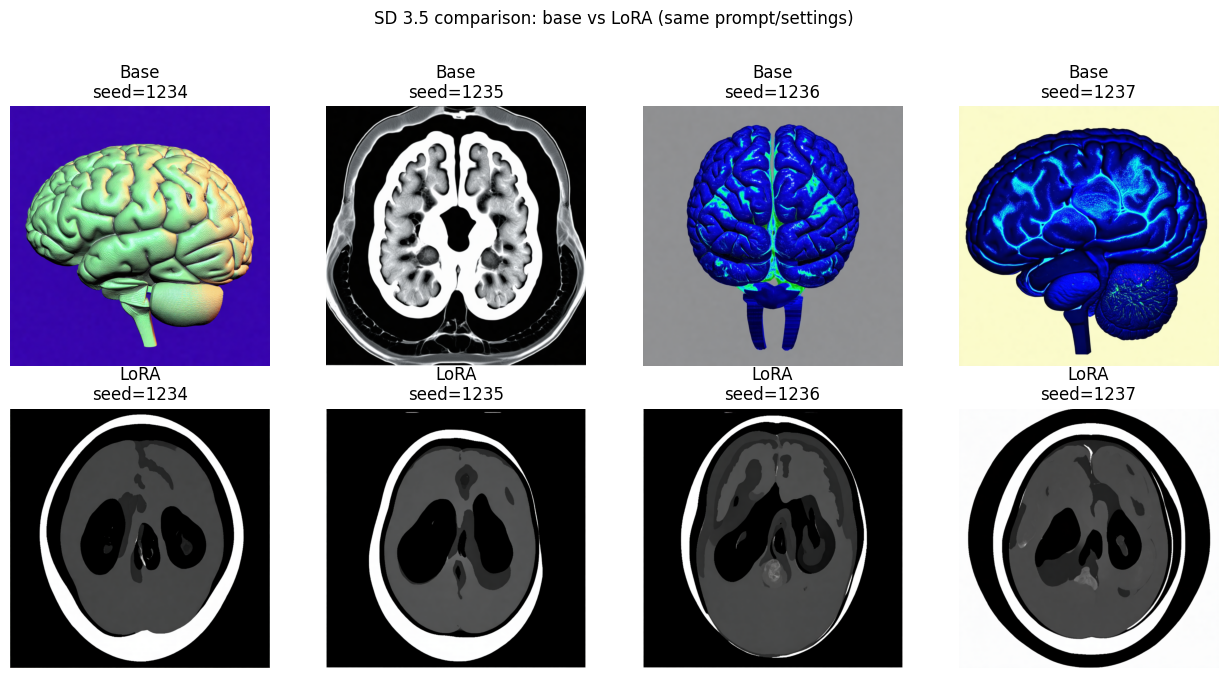

In [13]:
import matplotlib.pyplot as plt
import torch

# Compare base SD3.5 vs SD3.5+LoRA on the same prompt across multiple seeds.
# NOTE: this loads a second pipeline (base) so it can use extra VRAM.

PROMPT = 'A synthetic CT-style Shepp-Logan brain phantom showing normal-sized brain, enlarged ventricles, normal white matter, visible lesions'
NEGATIVE_PROMPT = None
STEPS = 30
GUIDANCE = 7.0

SEEDS = [1234, 1235, 1236, 1237]  # add/remove seeds as you like

# Use the existing `pipe` as the LoRA pipeline if it was loaded in step 9.
# We'll load a separate base pipeline (no LoRA) for comparison.
try:
    from diffusers import AutoPipelineForText2Image
except Exception as e:
    raise RuntimeError('diffusers is not available in this kernel.') from e

if 'pipe' not in globals():
    raise RuntimeError('`pipe` not found. Run the Step 9 cell (load SD 3.5 + apply LoRA) first.')

# Base (no LoRA) pipeline
base_pipe = AutoPipelineForText2Image.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    token=HF_TOKEN,
).to(device)

lora_pipe = pipe

def _make_gen(seed: int) -> torch.Generator:
    return (
        torch.Generator(device=device).manual_seed(seed)
        if device == 'cuda'
        else torch.Generator().manual_seed(seed)
    )

def _generate(pipeline, seed: int):
    out = pipeline(
        prompt=PROMPT,
        negative_prompt=NEGATIVE_PROMPT,
        num_inference_steps=STEPS,
        guidance_scale=GUIDANCE,
        generator=_make_gen(seed),
    )
    return out.images[0]

# Generate images
base_imgs = [_generate(base_pipe, s) for s in SEEDS]
lora_imgs = [_generate(lora_pipe, s) for s in SEEDS]

# Plot a 2 x N grid: top=base, bottom=LoRA
n = len(SEEDS)
fig, axes = plt.subplots(2, n, figsize=(3.2 * n, 6.6))
if n == 1:
    # matplotlib returns shape (2,) for n=1; normalize to (2,1)
    axes = [[axes[0]], [axes[1]]]

for j, seed in enumerate(SEEDS):
    ax = axes[0][j] if n == 1 else axes[0, j]
    ax.imshow(base_imgs[j])
    ax.axis('off')
    ax.set_title(f'Base\nseed={seed}')

    ax = axes[1][j] if n == 1 else axes[1, j]
    ax.imshow(lora_imgs[j])
    ax.axis('off')
    ax.set_title(f'LoRA\nseed={seed}')

plt.suptitle('SD 3.5 comparison: base vs LoRA (same prompt/settings)', y=1.02)
plt.tight_layout()
plt.show()

# Free up the extra base pipeline to reduce VRAM pressure after plotting.
del base_pipe
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Practical tips / common failure modes

- VRAM OOM: lower `RESOLUTION`, keep `TRAIN_BATCH_SIZE=1`, increase `GRADIENT_ACCUMULATION_STEPS`, keep `--gradient_checkpointing`.
- If `TRAIN_SCRIPT` args don’t match: run `python TRAIN_SCRIPT --help` and adjust the `cmd` list.
- If the model is gated: confirm you accepted SD 3.5 terms on Hugging Face and that `HF_TOKEN` is set (restart kernel after exporting).
- If outputs ignore your concept: improve captions (consistent token like `<my_subject>`), increase steps a bit, or raise `LORA_RANK` slightly.